# Convolutional Neural Networks with KERAS

In this notebook, various neural network models will be implemented to classify the images in the [CIFAR10] database (https://www.cs.toronto.edu/~kriz/cifar.html).

The CIFAR10 database consists of 32x32 pixel color images that belong to 10 classes:

- airplane (label 0)
- automobile (label 1)
- bird (label 2)
- cat (label 3)
- deer (label 4)
- dog (label 5)
- frog (label 6)
- horse (label 7)
- ship (label 8)
- truck (label 9)

The database is comprised of 60,000 records divided into two sets: 50,000 images for the training set and 10,000 images for the test set.

The exercise will involve building various models with the goal of achieving the highest accuracy in image classification. To do this, the following models will be implemented and analyzed:

A fully connected artificial neural network
A single-layer convolutional neural network
A deep convolutional neural network
In all cases, the Keras library with Tensorflow will be used for model implementation, compilation, and training.

Finally, predictions will be made with the best implemented model.


## 1. Downloading, analyzing, and preprocessing of the data.

In [1]:
import numpy as np
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [9]:
!pip install opencv-python

     --------------------------------------- 38.2/38.2 MB 22.6 MB/s eta 0:00:00


In [2]:
# dataset download CIFAR10 and make train/test partition
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


### 1.2 Data analysis

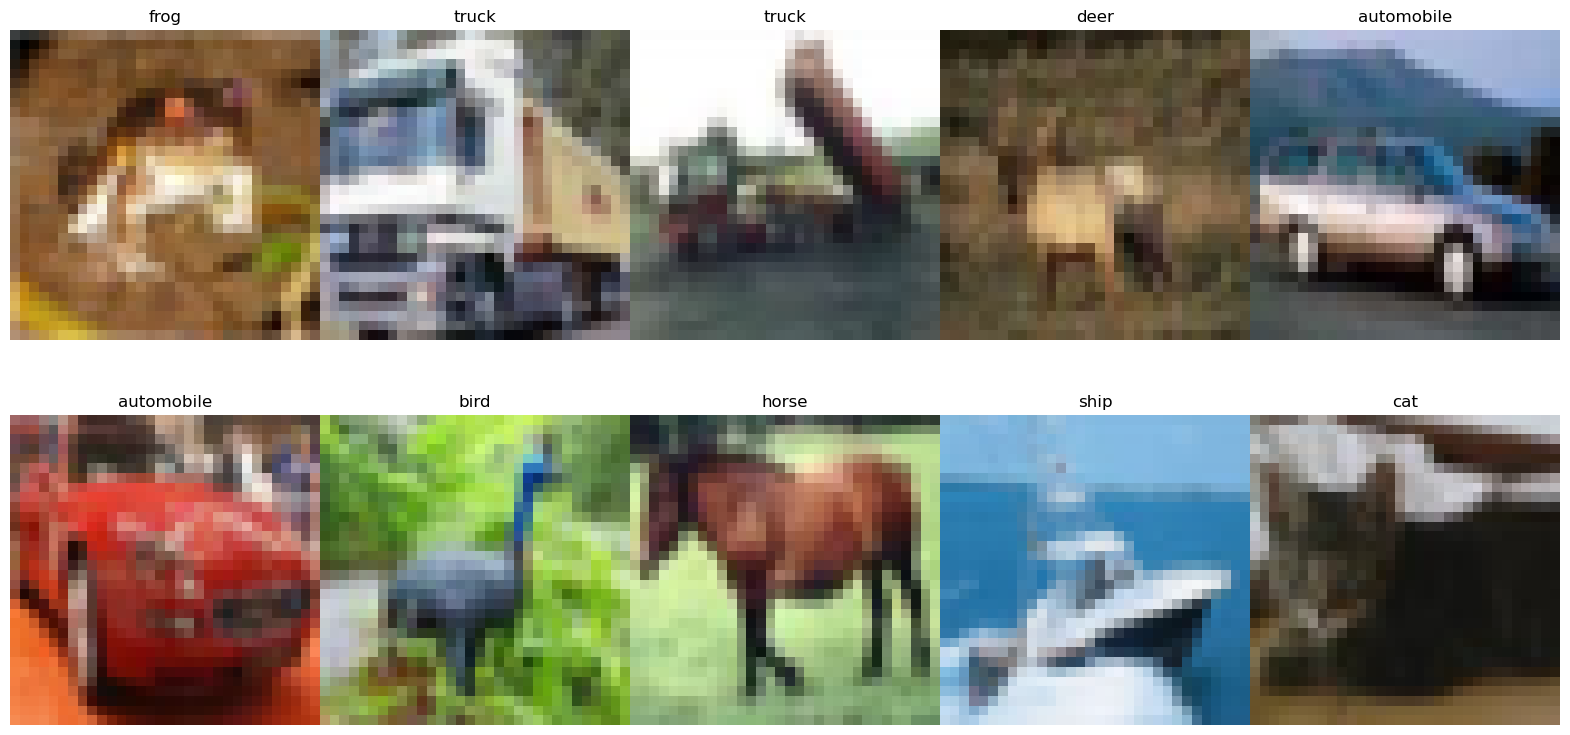

In [5]:
# Analysis of the downloaded data set
# Define texts by category
text_titles = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# Define the image grid
fig, axes1 = plt.subplots(2,5,figsize=(20,10))
fig.subplots_adjust(wspace=0, hspace=0)
i = 0
for j in range(2):
    for k in range(5):
        axes1[j][k].set_axis_off()
        axes1[j][k].set_title(text_titles[int(y_train[i])])
        axes1[j][k].imshow(X_train[i:i+1][0])
        i += 1

### 1.3 Data preprocessing
Since the images are in color, we will convert them to grayscale to perform the initial classifications. To do this, we will use the cvtColor function from the OpenCV (cv2) package.

In [10]:
import cv2

# Convert X_train and X_test to grayscale
X_train_grey = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_train])
X_test_grey = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_test])

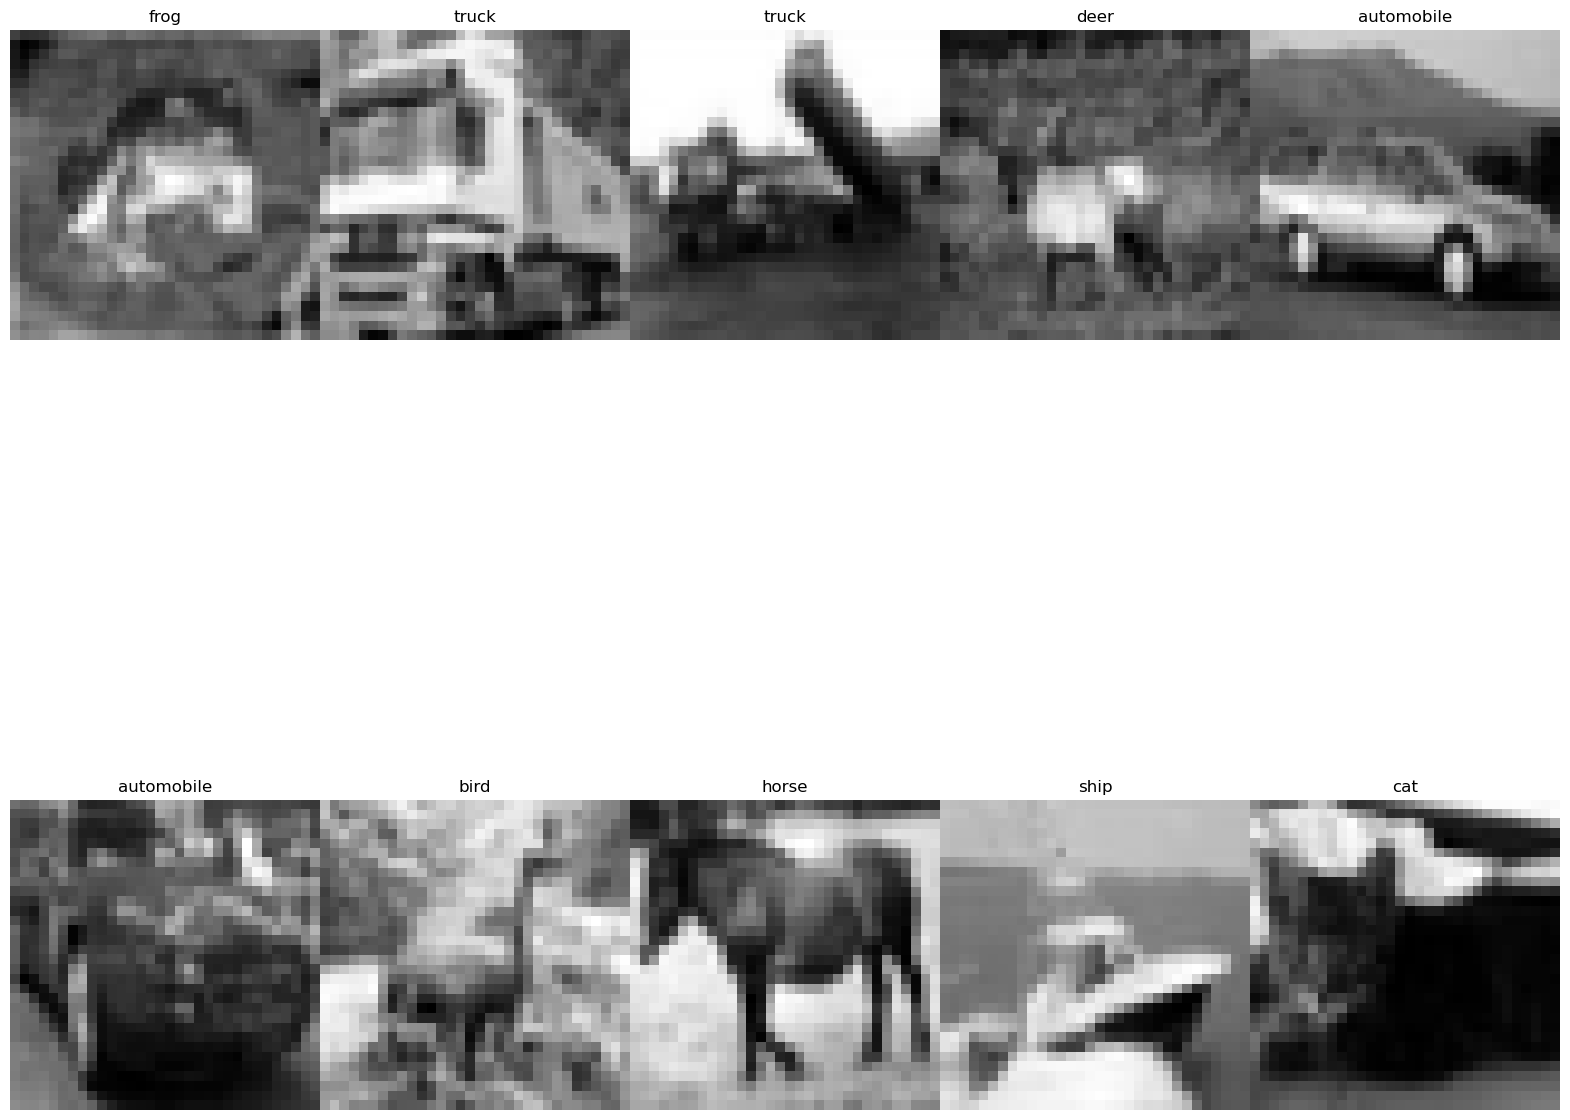

In [14]:
# define image grid
fig, axes1 = plt.subplots(2,5,figsize=(20,20))
fig.subplots_adjust(wspace=0, hspace=0)
i = 0
for j in range(2):
    for k in range(5):
        axes1[j][k].set_axis_off()
        axes1[j][k].set_title(text_titles[int(y_train[i])])
        axes1[j][k].imshow(X_train_grey[i:i+1][0], cmap="gray")
        i += 1

The first step in training a neural network is to preprocess the training and test data so that they fit the expected format for the inputs and outputs of the neural network. We will start by normalizing the input data so that they are in the range [0,1], as, as we can see below, they are integer values between 0 and 255.

In [15]:
print("The values of the first record of X_train_grey are: {}".format(X_train_grey[0]))

The values of the first record of X_train_grey are: [[ 62  45  47 ... 128 121 120]
 [ 20   0   7 ...  82  77  82]
 [ 23   6  24 ...  78  78  68]
 ...
 [152 123 125 ... 117  27  32]
 [131 104 115 ... 136  58  51]
 [139 123 130 ... 174 112  90]]


In [16]:
# Determine minimum and maximum values
v_min = np.min(X_train_grey)
v_max = np.max(X_train_grey)
print("The minimum and maximum values are {} and {}.".format(v_min, v_max))

The minimum and maximum values are 0 and 255.


Normalize the input data to the network so that it is compressed within the range [0,1]. Print the data of the first record once the normalization has been carried out and check the maximum and minimum values again.

In [17]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X_train_grey = NormalizeData(X_train_grey)
X_test_grey = NormalizeData(X_test_grey)

print("The values of the first record of X_train_grey normalized are: {}".format(X_train_grey[0]))
# Determine minimum and maximum values
v_min = np.min(X_train_grey)
v_max = np.max(X_train_grey)
print("The minimum and maximum values are {} and {}.".format(v_min, v_max))

The values of the first record of X_train_grey normalized are: [[0.24313725 0.17647059 0.18431373 ... 0.50196078 0.4745098  0.47058824]
 [0.07843137 0.         0.02745098 ... 0.32156863 0.30196078 0.32156863]
 [0.09019608 0.02352941 0.09411765 ... 0.30588235 0.30588235 0.26666667]
 ...
 [0.59607843 0.48235294 0.49019608 ... 0.45882353 0.10588235 0.1254902 ]
 [0.51372549 0.40784314 0.45098039 ... 0.53333333 0.22745098 0.2       ]
 [0.54509804 0.48235294 0.50980392 ... 0.68235294 0.43921569 0.35294118]]
The minimum and maximum values are 0.0 and 1.0.


Encode the values of the output labels into a one-hot vector. For example, the output vector for an image containing a 5 would be: [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]. Verify the result by printing its dimension and showing some record.

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("Dimensions after one_hot encoding on y_train: ",y_train.shape)
print("Dimensions after one_hot encoding on y_test: ",y_test.shape)
print("Example of encoded registry: ", y_train[10])

Dimensions after one_hot encoding on y_train:  (50000, 10)
Dimensions after one_hot encoding on y_test:  (10000, 10)
Example of encoded registry:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## 2. Fully Connected Artificial Neural Network (ANN)

Next, we will implement a feed-forward fully connected neural network and carry out training and testing on the CIFAR dataset.

### 2.1 Data preprocessing

Since in an artificial neural network the inputs are one-dimensional, the first thing we have to do is to reshape the input data (the images) to convert them into one-dimensional arrays.

The X_train_grey and X_test_grey sets will be modified so that their records are one-dimensional arrays of dimension 32x32 = 1024 data. The result will be checked by printing the dimensions of the variables.

In [19]:
X_train_gflat = np.array([value.flatten() for value in X_train_grey])
X_test_gflat = np.array([value.flatten() for value in X_test_grey])

print("Original dimensions of X_train_gray: ",X_train_grey.shape, ", after flatten: ",X_train_gflat.shape, " and every image: ", len(X_train_gflat[0]))
print("Original dimensions of X_test_gray: ",X_test_grey.shape, ", after flatten: ",X_test_gflat.shape, " and every image: ", len(X_train_gflat[0]),"\n")
print("Value example: ",X_train_gflat[10], " and dimension: ",X_train_gflat[10].shape)
print("Verify the value of pixel 1,10 in the first original image.:", X_train_grey[0][1][10], " with value 42 -corresponding to 32 + 10 - current: ", X_train_gflat[0][42])

Original dimensions of X_train_gray:  (50000, 32, 32) , after flatten:  (50000, 1024)  and every image:  1024
Original dimensions of X_test_gray:  (10000, 32, 32) , after flatten:  (10000, 1024)  and every image:  1024 

Value example:  [0.23529412 0.23137255 0.22352941 ... 0.22352941 0.23529412 0.18431373]  and dimension:  (1024,)
Verify the value of pixel 1,10 in the first original image.: 0.25098039215686274  with value 42 -corresponding to 32 + 10 - current:  0.25098039215686274


### 2.2 Model creation

It is to be noted that the Sequential model from Keras will be used. 

The architecture for the classification model will be designed with the following characteristics:

- 6 hidden layers with 128 neurons each.
- 3 Dropout layers with a rate of 20% (rate=0.2) interspersed every 2 dense layers.
- The activation function for the intermediate layers will be ReLU.
- One output layer with the appropriate dimensions and activation function to perform the classification.
- The model will be printed to view the number of parameters to be trained.
- The model will be compiled with the most suitable loss function, the SGD optimizer, a learning rate of 0.01 and the Accuracy metric.
- The model will be adjusted with 100 epochs and a batch size of 128. The training time will be measured.
- The accuracy and loss graphs will be displayed. Both graphs should display the training and validation curves. It is recommended to create a function that prints both graphs for reuse in future sections.
- The model will be evaluated to show the final loss and accuracy.

In [20]:
# Create the ANN model
ANN = keras.Sequential()
ANN.add(Dense(128, activation="relu", input_shape=(1024,)))
ANN.add(Dense(128, activation="relu"))
ANN.add(Dropout(0.2))
ANN.add(Dense(128, activation="relu"))
ANN.add(Dense(128, activation="relu"))
ANN.add(Dropout(0.2))
ANN.add(Dense(128, activation="relu"))
ANN.add(Dense(128, activation="relu"))
ANN.add(Dropout(0.2))
ANN.add(Dense(10, activation="softmax"))

ANN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               1

In [21]:
# Compile
ANN.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])

In [22]:
# Train the model
start=time.time()
ANN_fitted = ANN.fit(X_train_gflat, y_train, epochs=100, batch_size=128, validation_data=(X_test_gflat, y_test), verbose = 0)
end=time.time()
print("ANN training time: ","{:.2f}".format(end-start),"s")

ANN training time:  150.50 s


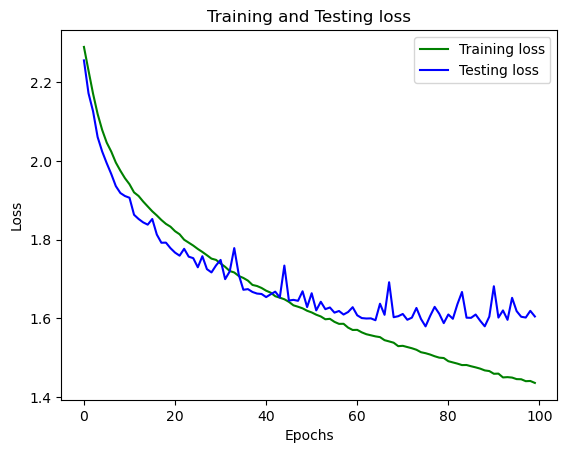

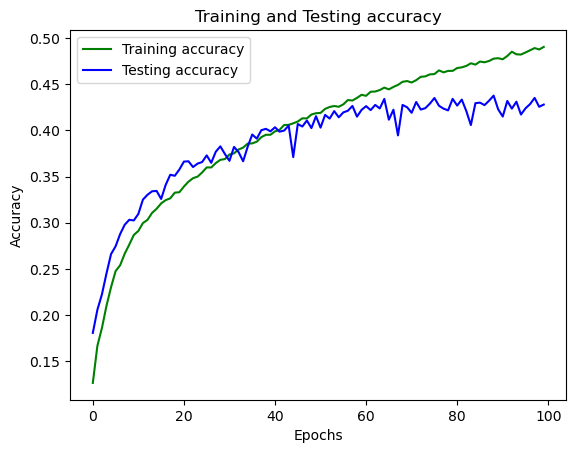

In [23]:
# Plot training loss and accuracy
def plot_prediction(n_epochs, mfit):
  loss_train = mfit.history['loss']
  loss_val = mfit.history['val_loss']
  epochs = range(0,n_epochs)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='Testing loss')
  plt.title('Training and Testing loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  acc_train = mfit.history['accuracy']
  acc_val = mfit.history['val_accuracy']
  plt.plot(epochs, acc_train, 'g', label='Training accuracy')
  plt.plot(epochs, acc_val, 'b', label='Testing accuracy')
  plt.title('Training and Testing accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

plot_prediction(100,ANN_fitted)

In [24]:
# Results
print("Evaluate on test data")
results = ANN.evaluate(X_test_gflat, y_test, batch_size=128)
print("ANN test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 1.6045 - accuracy: 0.4281
ANN test loss, test acc: [1.6044731140136719, 0.42809998989105225]


## 3. One-layer Convolutional Neural Network.

We will implement a single layer convolutional neural network and conduct training and testing on the CIFAR dataset.

It is recommended, from this point, to perform the training on a machine with a GPU (it can be activated on platforms such as Google Colab or Kaggle) in order to reduce the training times.

### 3.1 Data preprocessing

The first step in training a neural network involves preprocessing the training and test data so that they match the input dimensions of the neural network.

The size of the training and test data is adjusted so that they have 4 dimensions (the last dimension must be 1 to indicate that the images are in grayscale).

In [25]:
X_train_CNN = X_train_grey.reshape(50000,32,32,1)
X_test_CNN = X_test_grey.reshape(10000,32,32,1)

### 3.2 Model creation

It is to be implemented the Sequential model of Keras with the following characteristics:

- The first layer that will be added is a convolutional layer with the following properties:
    - Number of kernels (neurons) of the first hidden layer: 64 neurons
    - Kernel size: 3x3
    - Kernel activation: ReLU
- Then, a Flatten layer will be added to connect the output of the convolutional layer to the input of a dense layer.
- Finally, a dense output layer will be added with the appropriate number of neurons and activation function to perform the classification.

Build the model according to the indicated requirements. Additionally:

- Print the model to see the number of parameters to be trained.
- Compile the model with the most appropriate loss function, the ADAM optimizer, and the Accuracy metric.
- Fit the model with 20 epochs and a batch size of 128. Measure the training time.
- Show the accuracy and loss plots. On each plot, the training and validation curves should be visualized.
- Carry out the evaluation of the model to show the final loss and accuracy.

In [26]:
# Create the one-layer CNN
CNN = Sequential()

# Add layers
CNN.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(32,32,1)))
CNN.add(Flatten())
CNN.add(Dense(10, activation="softmax"))

CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense_7 (Dense)             (None, 10)                576010    
                                                                 
Total params: 576,650
Trainable params: 576,650
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Model training
start = time.time()
CNNfit = CNN.fit(X_train_CNN, y_train, validation_data=(X_test_CNN, y_test), batch_size=128, epochs=20, verbose = 0)
end=time.time()
print("CNN training time: ","{:.2f}".format(end-start),"s")

CNN training time:  317.52 s


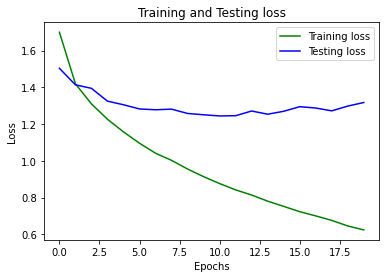

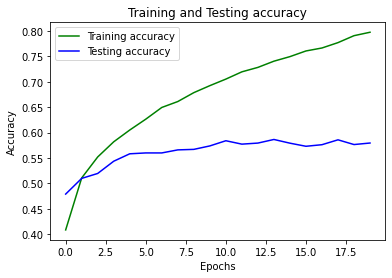

Evaluate on test data
79/79 [==============================] - 0s 4ms/step - loss: 1.3175 - accuracy: 0.5794
CNN test loss, test acc: [1.3174737691879272, 0.5794000029563904]


In [20]:
# Results
plot_prediction(20,CNNfit)
print("Evaluate on test data")
results = CNN.evaluate(X_test_CNN, y_test, batch_size=128)
print("CNN test loss, test acc:", results)

## 4. Deep CNN with Maxpooling and Dropout

In the previous section, a single-layer convolutional network was implemented. Now, a deep convolutional neural network will be implemented and its impact on the results' performance will be observed.

### 4.1 Model creation

In this case, the Sequential model from Keras will be used again, consisting of:

- Two convolutional layers with 32 kernels each with a size of 3x3
- A MaxPooling layer with a size of 2x2
- A Dropout layer with a rate=0.2
- Two convolutional layers with 64 kernels each with a size of 3x3
- A MaxPooling layer with a size of 2x2
- A Dropout layer with a rate=0.2
- Two convolutional layers with 128 kernels each with a size of 3x3
- A MaxPooling layer with a size of 2x2
- A Dropout layer with a rate=0.2
- All convolutional layers with ReLU activation function and padding = same
- A Flatten layer
- A dense layer with 128 neurons and ReLU activation function
- A Dropout layer with a rate=0.2
- An output dense layer with the necessary number of neurons and activation function for performing the classification.

In [21]:
# Create deep CNN

DeepCNN = keras.Sequential()

DeepCNN.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
DeepCNN.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNN.add(MaxPooling2D(2, 2))
DeepCNN.add(Dropout(0.2))
DeepCNN.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNN.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNN.add(MaxPooling2D(2, 2))
DeepCNN.add(Dropout(0.2))
DeepCNN.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNN.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNN.add(MaxPooling2D(2, 2))
DeepCNN.add(Dropout(0.2))
DeepCNN.add(Flatten())
DeepCNN.add(Dense(128, activation="relu"))
DeepCNN.add(Dropout(0.2))
DeepCNN.add(Dense(10, activation="softmax"))

DeepCNN.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)         

In [22]:
# Compile
opt = SGD(learning_rate=0.001, momentum=0.9)
DeepCNN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	

In [23]:
# Train the model
start = time.time()
DeepCNNfit = DeepCNN.fit(X_train_CNN, y_train, validation_data=(X_test_CNN, y_test), batch_size=128, epochs=150, verbose = 0)
end=time.time()
print("DeepCNN training time: ","{:.2f}".format((end-start)/60),"min")

Temps d'entrenament DeepCNN:  7.28 min


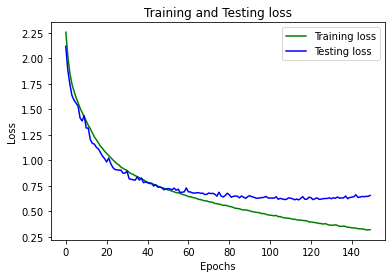

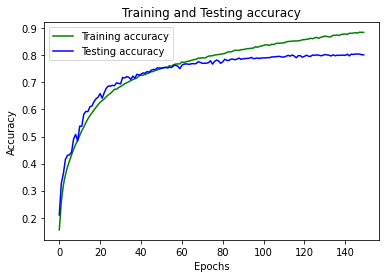

Evaluate on test data
79/79 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.8020
DeepCNN test loss, test acc: [0.6549292802810669, 0.8019999861717224]


In [24]:
# Results
plot_prediction(150,DeepCNNfit)
print("Evaluate on test data")
results = DeepCNN.evaluate(X_test_CNN, y_test, batch_size=128)
print("DeepCNN test loss, test acc:", results)

### 4.2 CNN with color images

Finally, the influence of the color of the images on the classification performance will be studied.

For this, a convolutional network with the same structure as the network in the previous section will be used, but changing the input layer so that the original color images, arrays of dimension (32, 32, 3), can be introduced.

In [25]:
# Normalize
X_train_norm = NormalizeData(X_train)
X_test_norm = NormalizeData(X_test)


In [26]:
# Create deep CNN with RGB
DeepCNNRGB = keras.Sequential()

DeepCNNRGB.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
DeepCNNRGB.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNNRGB.add(MaxPooling2D(2, 2))
DeepCNNRGB.add(Dropout(0.2))
DeepCNNRGB.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNNRGB.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNNRGB.add(MaxPooling2D(2, 2))
DeepCNNRGB.add(Dropout(0.2))
DeepCNNRGB.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNNRGB.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
DeepCNNRGB.add(MaxPooling2D(2, 2))
DeepCNNRGB.add(Dropout(0.2))
DeepCNNRGB.add(Flatten())
DeepCNNRGB.add(Dense(128, activation="relu"))
DeepCNNRGB.add(Dropout(0.2))
DeepCNNRGB.add(Dense(10, activation="softmax"))

DeepCNNRGB.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)         

In [27]:
# Compile
DeepCNNRGB.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model
start = time.time()
DeepCNNRGBfit = DeepCNNRGB.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), batch_size=128, epochs=150, verbose = 0)
end=time.time()
print("DeepCNNRGB training time: ","{:.2f}".format((end-start)/60),"min")

Temps d'entrenament DeepCNNRGB:  7.30 min


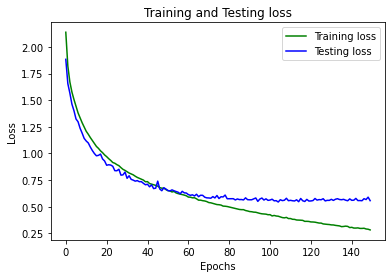

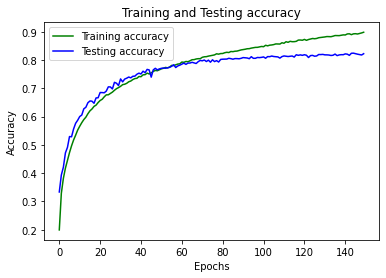

Evaluate on test data
79/79 [==============================] - 0s 4ms/step - loss: 0.5564 - accuracy: 0.8226
DeepCNN test loss, test acc: [0.5563539862632751, 0.8226000070571899]


In [29]:
# Results
plot_prediction(150,DeepCNNRGBfit)
print("Evaluate on test data")
results = DeepCNNRGB.evaluate(X_test_norm, y_test, batch_size=128)
print("DeepCNN test loss, test acc:", results)

## 5. A comparison of the implemented models and prediction.

It has been found that the study started by training a fully connected artificial neural network (ANN), followed by a single-layer convolutional neural network (CNN), and then a deep network with Maxpooling and Dropout, both for black and white images (DeepCNN) and color images (DeepCNNRGB). The differences are analyzed as follows:

**Accuracy**: The accuracy obtained with the ANN was only 0.437. The accuracy obtained with the CNN increased to 0.578. The accuracy obtained by the DeepCNN and the DeepCNNRGB was 0.813 and 0.827 respectively. As can be seen, the best precision has been with deep networks, both in black and white and color (there is little difference between them, so it is really indifferent to use color or black and white images). What is observed is that the model of a fully connected neural network is unable to obtain a satisfactory accuracy. And that deep networks need Dropout and Maxpooling layers to improve their training (going from 0.578, a very poor precision, to 0.813, a precision already very acceptable).

**Loss**: Recall that the loss is a scalar value that we try to minimize during the model training. The lower the loss, the closer our predictions are to the actual labels. If we observe the losses for the different models tested, we see that for the ANN the loss has been 1.57. For the CNN, we obtained a loss of 1.29. For the DeepCNN and DeepCNNRGB models with Maxpooling and Dropout, we obtained a loss of 0.62 for black and white images and 0.57 for color images. So we observe that the predictions for the DeepCNN and DeepCNNRGB models with Maxpooling and Dropout will be much better than with other models, as the loss values are closest to zero.

**Training time**: The training time varies depending on the complexity of the models. Processing all the training with GPU to compare better, we see that for the fully connected artificial neural network ANN, we have a training time of 142.8 seconds. For the CNN, we have a training time of 28.8 s. For the DeepCNN and DeepCNNRGB models, we have almost identical times of 7.24 minutes and 7.22 minutes. We see that the single-layer convolutional network is the fastest, with only 28.8s, although this network trained only with CPU (without GPU) takes about 10 minutes. We also see that training the network with black and white or color data has no differences. This is because the RGB channels are parallel and therefore, the time to train one of the channels is very similar to training the single channel of black and white images. And as they go in parallel the times do not add up and are almost identical.

**Number of parameters to be trained**: We can observe the difference in parameters to be trained. For the ANN, we have to train 215,050 parameters. For the CNN, we have to train 576,650 parameters. For the DeepCNN 549,994 (black and white) and 550,570 (color). We observe that the fully connected artificial neural network has the worst relationship training time vs. parameters, as despite having the smallest number of parameters, it has a fairly high training time (142.8 seconds).

From these results, the following can be deduced:

- In deep neural networks, training with data of the same dimensions seems to be practically independent of the layers. This is deduced from comparing deep neural networks with black and white images (1 layer) with respect to color images (3 layers) where we see that the times and accuracy are very similar, even though the results with color images are better. It is believed that this is due to the color, as a shade of gray can correspond to many different colors, colors that can help categorize an image.

- It is seen that fully connected artificial neural networks are not optimal for image classification (they have very low accuracy and too much loss), and also have a processing time that is too high for their "simplicity".

- We also observe the need to include Maxpooling and Dropout layers in deep neural networks, as even though they increase training time, the model improves greatly in accuracy and loss.

Seeing the results, the best model is believed to be the deep neural network with Maxpooling and Dropout and with color images, as they provide an additional advantage of accuracy and loss compared to black and white images, without penalizing training time or parameters to be trained.

### 5.2 Best solution analysis

In [30]:
# Prediction
y_pred = DeepCNNRGB.predict(X_test_norm)

# convert prediction to categorical
y_pred = np.argmax(y_pred, axis=-1)
y_test = np.argmax(y_test, axis=-1)

# print report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.88      0.93      0.91      1000
           2       0.77      0.74      0.75      1000
           3       0.67      0.65      0.66      1000
           4       0.80      0.81      0.80      1000
           5       0.76      0.74      0.75      1000
           6       0.83      0.89      0.86      1000
           7       0.88      0.84      0.86      1000
           8       0.90      0.90      0.90      1000
           9       0.90      0.87      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



[Text(0, 0.5, 'airplane'),
 Text(0, 1.5, 'automobile'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'sheep'),
 Text(0, 9.5, 'truck')]

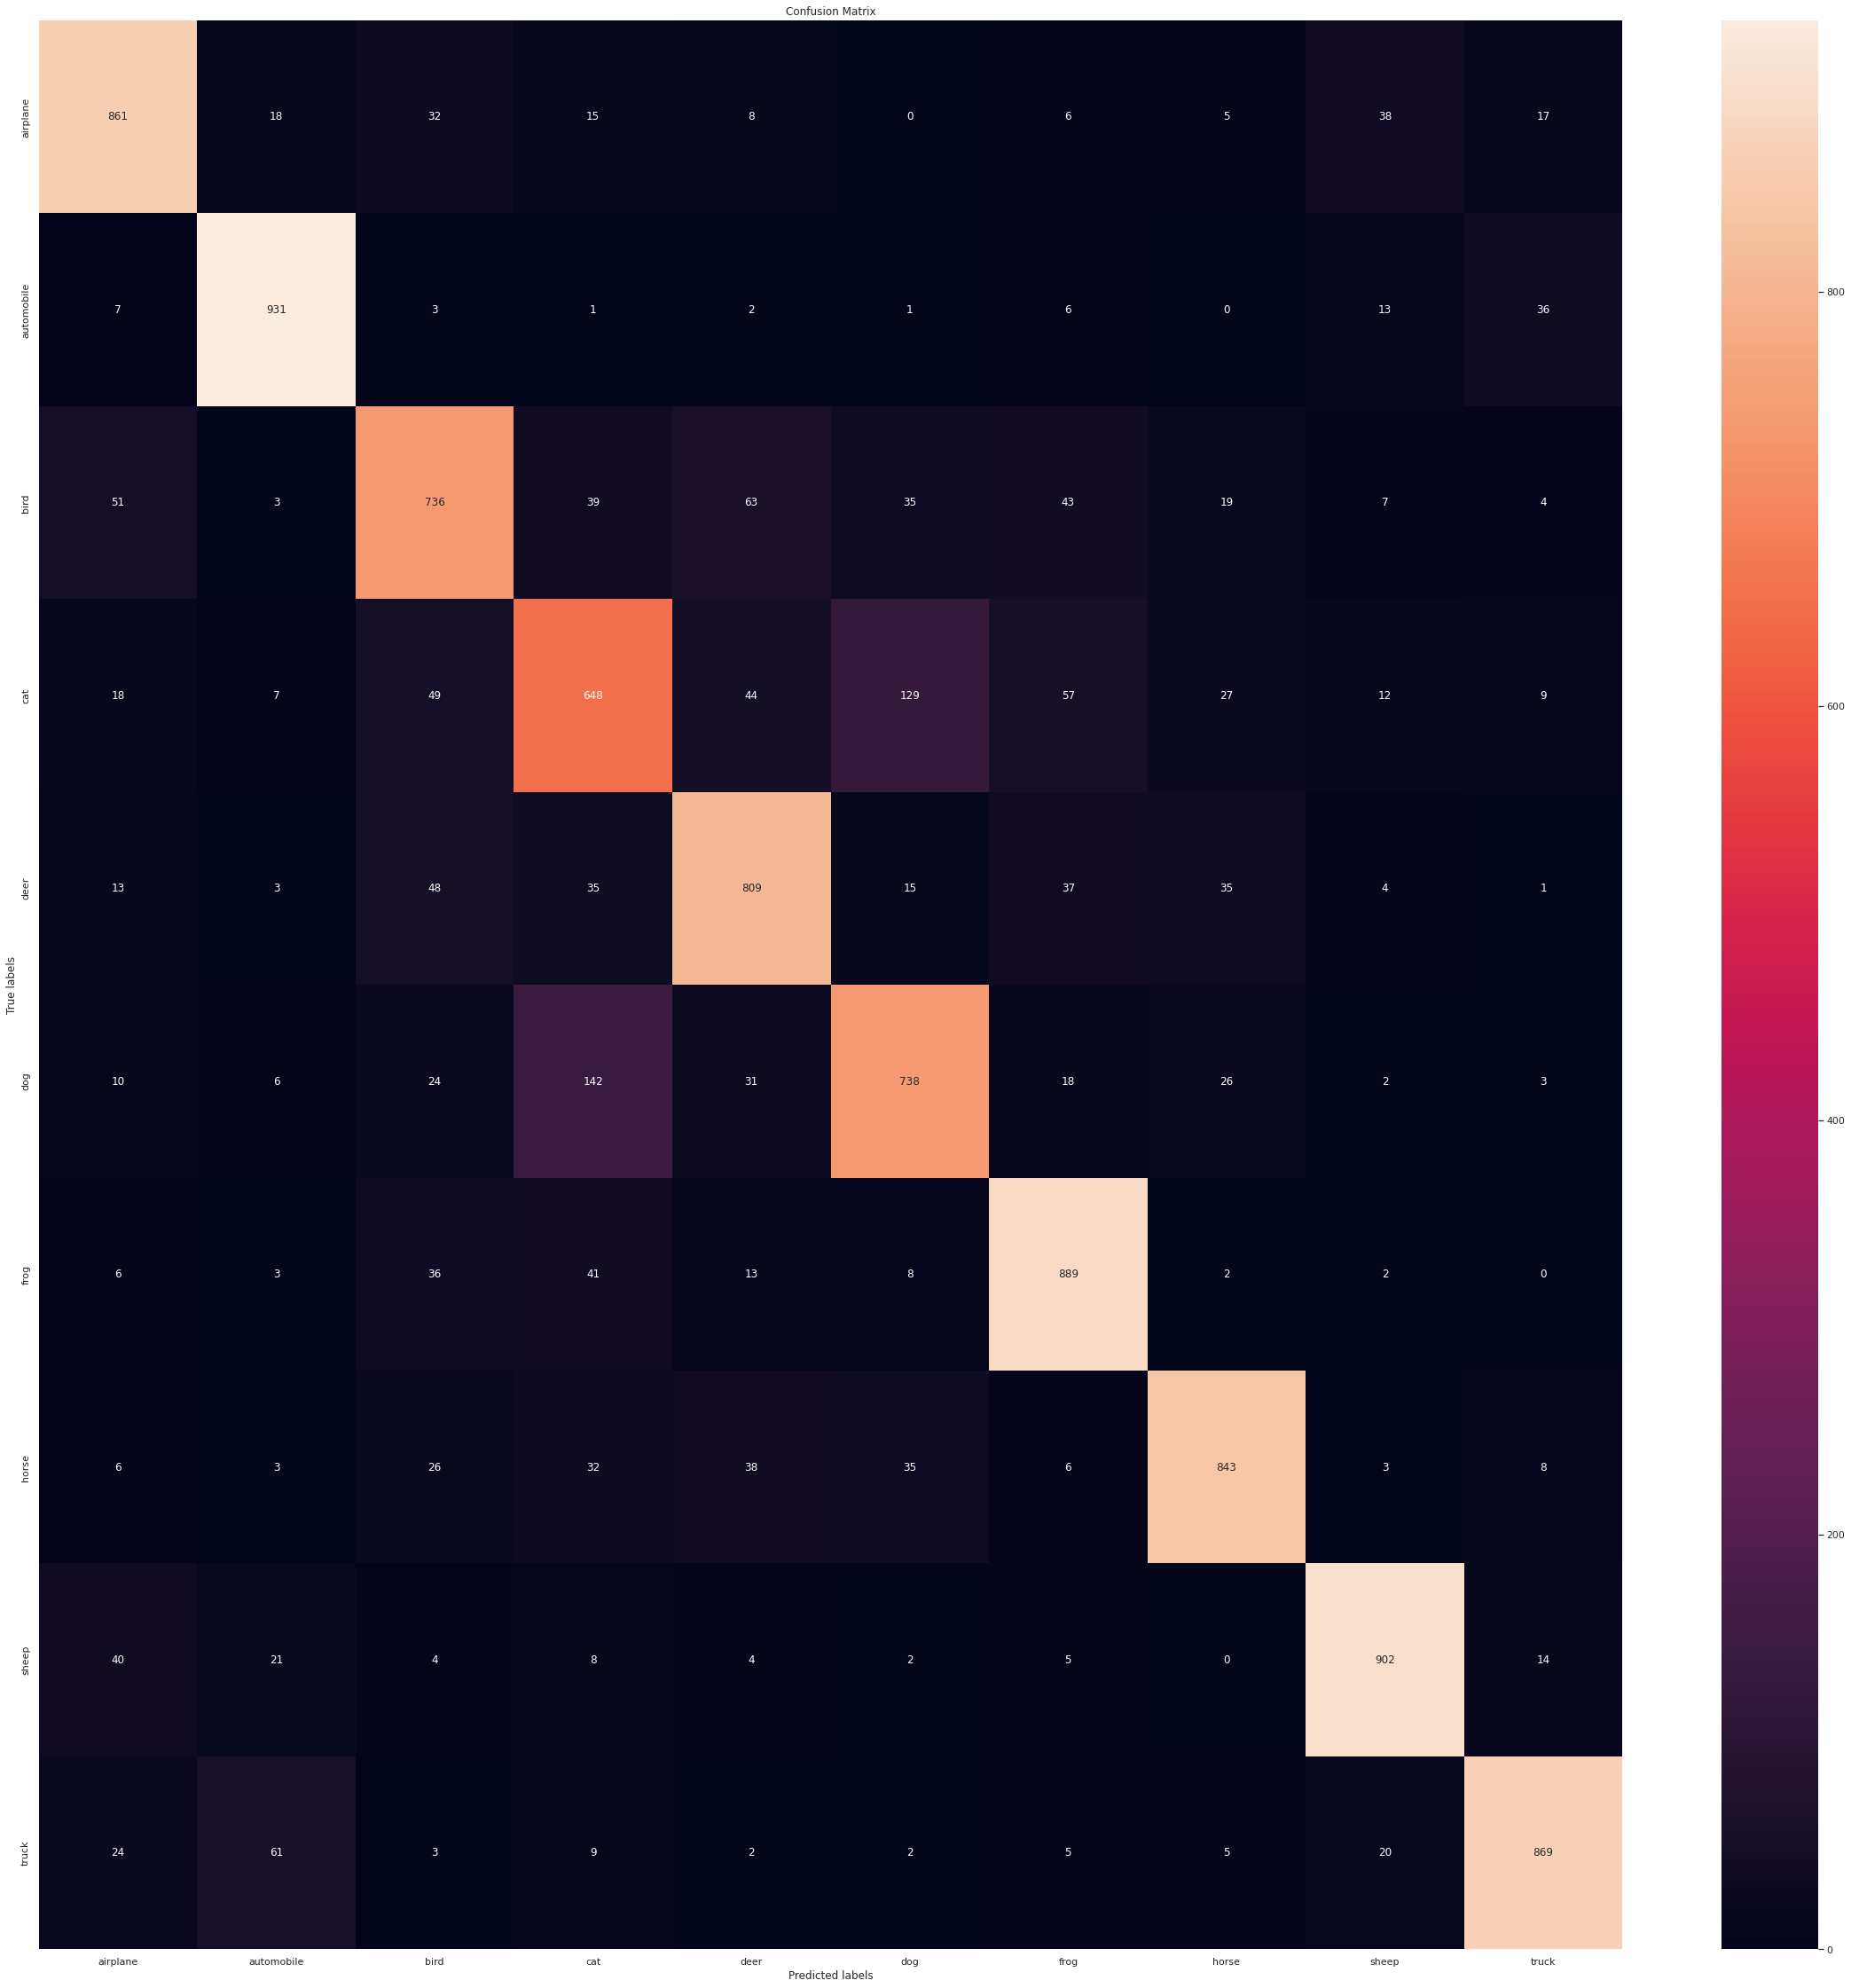

In [57]:
# Confussion Matrix
# calculate confussion matrix
matrix = confusion_matrix(y_test, y_pred)

# plot confussion matrix and the labels
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax)
sns.set(rc={'figure.figsize':(40,40)})

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['airplane','automobile','bird','cat','deer','dog','frog','horse','sheep','truck'])
ax.yaxis.set_ticklabels(['airplane','automobile','bird','cat','deer','dog','frog','horse','sheep','truck'])

It is seen that the type of image with the best recall (the percentage of positive predictions over the total of true positives) is for cars, which achieve a 0.92. Since there are 1000 images for each type, it is easily observed which images are predicted better (those with a higher value on the diagonal).

### 5.3 Prediction of some images from the test set.

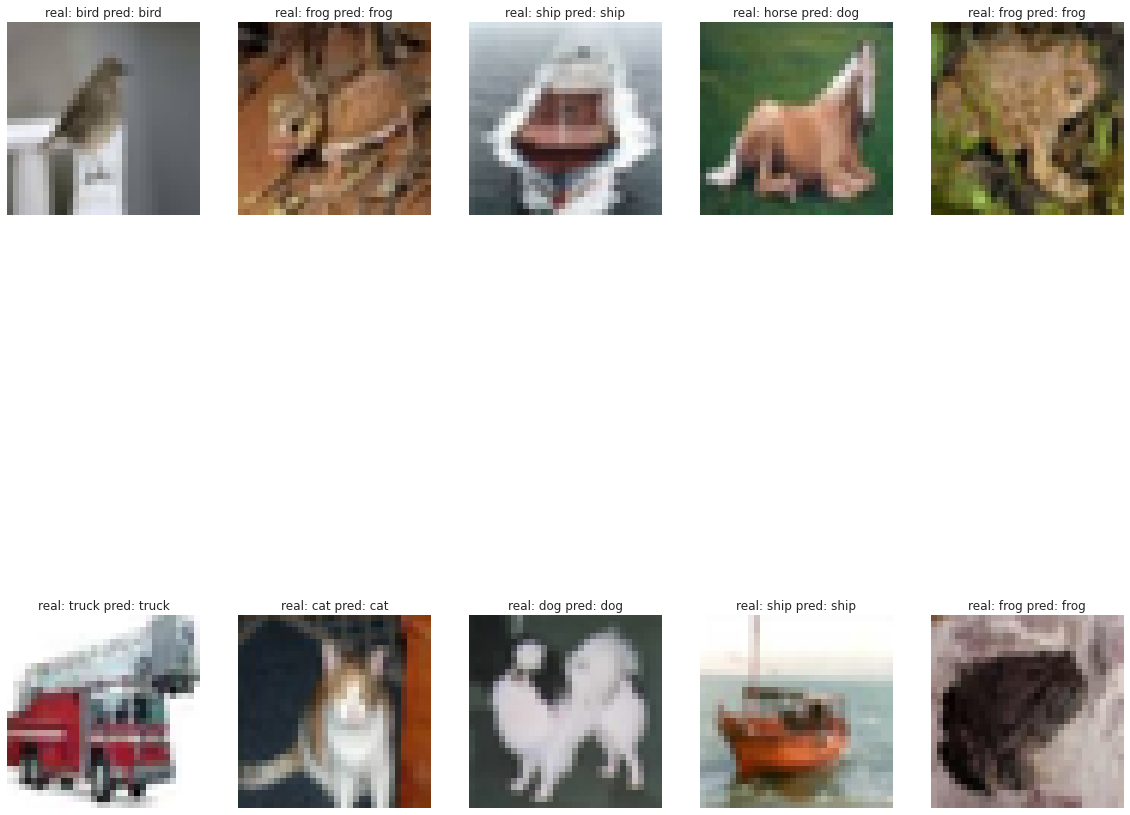

In [55]:
# Visualization
from random import randrange
# Show them as they are generated with random. 
# Define the grid of images.
fig, axes1 = plt.subplots(2,5,figsize=(20,20))
# The random counter is initialized.
im = 0
for j in range(2):
    for k in range(5):
        im = randrange(10000)
        axes1[j][k].set_axis_off()
        title = "real: " + text_titles[int(y_test[im])] + " pred: " + text_titles[int(np.argmax(
            DeepCNNRGB.predict((X_test_norm[im:im+1][0]).reshape(1,32,32,3)), axis=-1))]
        axes1[j][k].set_title(title)
        axes1[j][k].imshow(X_test[im:im+1][0])

It is seen that the predictions are quite good. In fact, it is seen that it only fails in the horse, seeing it as a dog. But honestly, it has been hard to see that it was a horse and it is indeed a photo that can resemble a dog.